# Titanic Dataset Analysis

# Introduction

Hello. My name is Evan Freeman. Here's my analysis of the passengers of the Titanic.  I'm going to create a machine learning model to predict whether or not a passenger survived based on information like sex, class, and age.

I'm working on this Kaggle competition:  
https://www.kaggle.com/c/titanic/overview

Also, in general, when I've looked up information on the passengers, it's been through:  
https://www.encyclopedia-titanica.org/

# To Do

1. Add a table of contents
2. Add in other models for comparison: Tree, Random Forest, XGBoost (nah, XGBoost is bad and slow), Neural Net?
3. Generate more features (Group Size)
4. Scale data, probably normal distribution (DONE, didn't seem to help much, should I scale target values as well? Also, should I scale one hot values at all?)
5. Further hyperparameter tuning, and learn about what all the model parameters do
6. Discuss Explainability in the model (feature importance is a big part of this, but perhaps also use LIME or other perturbation analysis)
7. Add a description of the linear model
8. Do more data exploration before preprocessing, then again after preprocessing
9. Do one-hot instead of label encoding for comparison
10. Discuss the correlation matrix more
11. Scale y data, then reverse scale after modeling?
    1. Is this correct?
    2. Honestly, not sure about this whole scaling thing. PCA breaks without scaling, but everything else seems fine without it.
12. Do a 1D PCA graph, to show how we get more separation as we add in Principal Components

# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML
import re
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 20
pd.options.display.max_rows = 30

filepath = 'D:/code/Data/titanic/'

titanic = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

# Also, we're going to need the test ids for submission, so let's grab those

test_id = test['PassengerId']

# Exploring the Data

In [2]:
display(titanic)
titanic.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Here's some explanations about the data, taken from the datafiles

Data Dictionary:  


Variable	Definition	Key  
survival	Survival	0 = No, 1 = Yes  
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
sex	Sex	  
Age	Age in years	 
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  

Variable Notes  
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Let's clean up the missing data:

# Data Cleaning

Let's check missing numbers, impute where needed.

In [3]:
display(titanic.isnull().sum())
print('')
display(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Cabin

Well shoot! We're missing most of the cabin info (There's only 891 rows total). Let's drop it. I guess we could come back and manually add that in someday, but that seems like a waste of time.

In [4]:
titanic = titanic.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

## Embarked

Let's see which Embarked Locations are missing. We might be able to look those up online.

In [5]:
for i, row in titanic.iterrows():
    if row.isnull().Embarked:
            print(row)

PassengerId                     62
Survived                         1
Pclass                           1
Name           Icard, Miss. Amelie
Sex                         female
Age                             38
SibSp                            0
Parch                            0
Ticket                      113572
Fare                            80
Embarked                       NaN
Name: 61, dtype: object
PassengerId                                          830
Survived                                               1
Pclass                                                 1
Name           Stone, Mrs. George Nelson (Martha Evelyn)
Sex                                               female
Age                                                   62
SibSp                                                  0
Parch                                                  0
Ticket                                            113572
Fare                                                  80
Embarked             

1. Miss Rose Amélie Icard boarded the Titanic at Southampton as maid to Mrs George Nelson Stone.  
2. Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.  

So let's set both of their Embarked values to 'S'.

In [6]:
titanic.loc[61, 'Embarked'] = 'S'
titanic.loc[829, 'Embarked'] = 'S'

In [7]:
for i, row in test.iterrows():
    if row.isnull().Embarked:
            print(row)

Good, we've taken care of them all, now.

## Age

Hmm, age could be a bit trickier. Let's just impute the mean age to all the missing for now. Some day when we have more time we could actually look up all the missing ages and put them in. Or we could impute seperately for Men vs Women to be a bit more accurate.

In [8]:
# I'm a little confused as to why this worked, but whatever.
titanic['Age'] = SimpleImputer().fit_transform(titanic[['Age']])
test['Age'] = SimpleImputer().fit_transform(test[['Age']])

## Fare

Also, one of the test cases is missing their fare, so just impute that as well.

In [9]:
test['Fare'] = SimpleImputer().fit_transform(test[['Fare']])

## Check

In [10]:
display(titanic.isnull().sum())
print('')
display(test.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [11]:
display(titanic)
display(test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,S


# Further Feature Generation

At this point, we might start to think about additional feature engineering. I ran across an interesting Kernal on Kaggle, that generates a couple more very interesting features. All credit to Bhargav Purohit.  
https://www.kaggle.com/bhargavpurohit/titanic-top-6-using-only-random-forest

He adds two additional features: title and group size. For now, let me just work on the title.  

Note that I've glanced through his Kernal for the idea to do these features, but I'm going to try to code them myself.

It's worth noting that Cabin number could be useful for finding group size, in addition to other factors.

In [12]:
title = set()
for name in titanic['Name']:
    words = name.split()
    for word in words:
        if '.' in word:
            title.add(word)
                      
display(title)

title_test = set()
for name in test['Name']:
    words = name.split()
    for word in words:
        if '.' in word:
            title_test.add(word)
            
display(title_test)

title = title | title_test

{'Capt.',
 'Col.',
 'Countess.',
 'Don.',
 'Dr.',
 'Jonkheer.',
 'L.',
 'Lady.',
 'Major.',
 'Master.',
 'Miss.',
 'Mlle.',
 'Mme.',
 'Mr.',
 'Mrs.',
 'Ms.',
 'Rev.',
 'Sir.'}

{'Col.', 'Dona.', 'Dr.', 'Master.', 'Miss.', 'Mr.', 'Mrs.', 'Ms.', 'Rev.'}

It mostly looks good. But, what about 'Don.', 'Jonkheer.', 'L.', 'Mlle.', 'Mme.'? Let's check each of these.

Based on my research / googling, 'Mlle.' is short for mademoiselle, which is French for 'Ms.'

'Mme.' is French for 'Madame.', which might be the same as Mrs.? Unclear.

Jonkheer (female equivalent: jonkvrouw; French: Écuyer) is an honorific in the Low Countries denoting the lowest rank within the nobility.

"Don' is an honorific in Mexico and other countries.

However, 'L.' is just an abbreviated middle name, so we'll remove it from the list.

In [13]:
title.remove('L.')

Let's make sure that no one has more or less than one prefix.

In [14]:
for i, row in titanic.iterrows():
    count = 0
    for honor in list(title):
        if honor in row['Name'].split():
            count += 1
    if count != 1:
        print(i, count)

In [15]:
for i, row in test.iterrows():
    count = 0
    for honor in list(title):
        if honor in row['Name'].split():
            count += 1
    if count != 1:
        print(i, count)
        display()

In [16]:
display(title)

{'Capt.',
 'Col.',
 'Countess.',
 'Don.',
 'Dona.',
 'Dr.',
 'Jonkheer.',
 'Lady.',
 'Major.',
 'Master.',
 'Miss.',
 'Mlle.',
 'Mme.',
 'Mr.',
 'Mrs.',
 'Ms.',
 'Rev.',
 'Sir.'}

Good, looks like we're set to add this feature.

Ok, we need to standardize these labels if we want to do one-hot later on. Also, the feature will probably be of more value if we help group them together into meaningful categories. So we'd have to come up with some sort of translation (i.e. 'Mlle' = 'Ms.'). I'll use the grouping and a modified key from that Kernal. (I have to account for periods in my version).

1. Mr
2. Mrs
3. Master
4. Royal
5. Officer
6. Miss

In [17]:
title_map={
    "Mr.": "Mr", 
    "Mrs.": "Mrs", 
    "Miss.": "Miss", 
    "Master.": "Master", 
    "Don.": "Royal", 
    "Rev.": "Officer", 
    "Dr.": "Officer",
    "Mme.": "Mrs", 
    "Dona.": "Royal", 
    "Jonkheer." : "Royal", 
    "Countess.": "Royal", 
    "Capt.": "Officer", 
    "Col.": "Officer",
    "Ms.": "Mrs", 
    "Mlle.": "Miss", 
    "Major.": "Officer", 
    "Lady." : "Royal", 
    "Sir." : "Royal"
    }

def get_title(string):
    for word in title:
        if word in string.split():
            return title_map[word]
    
titanic['Title'] = titanic['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

In [18]:
display(titanic)
display(test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S,Officer
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C,Mr


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,S,Mrs
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C,Royal
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,S,Mr


# More Preprocessing

Ok, we're done with names and passenger ids now, so let's drop those. And ticket number doesn't seem that useful.

In [19]:
titanic = titanic.drop(['Name', 'PassengerId', 'Ticket'], axis = 1)
test = test.drop(['Name', 'PassengerId', 'Ticket'], axis = 1)

Yes! Our data looks beautiful. Let's get to work.

# Plotting the Data

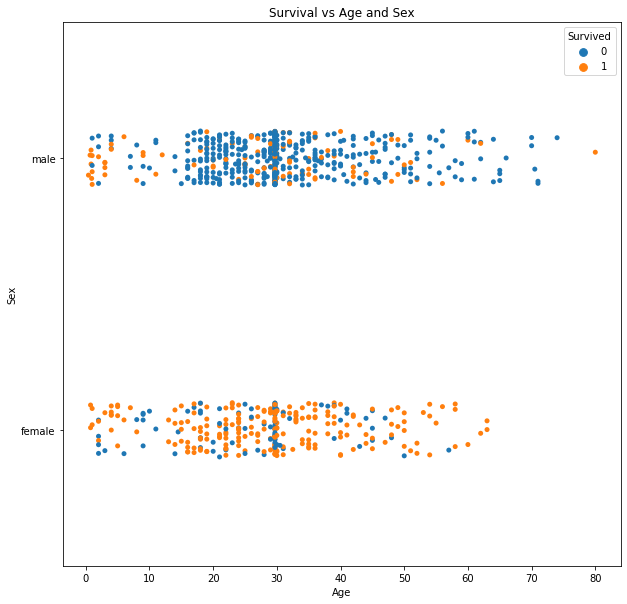

In [20]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'Age', y = 'Sex', hue = 'Survived', data = titanic)
plt.title(f'Survival vs Age and Sex')
plt.show()

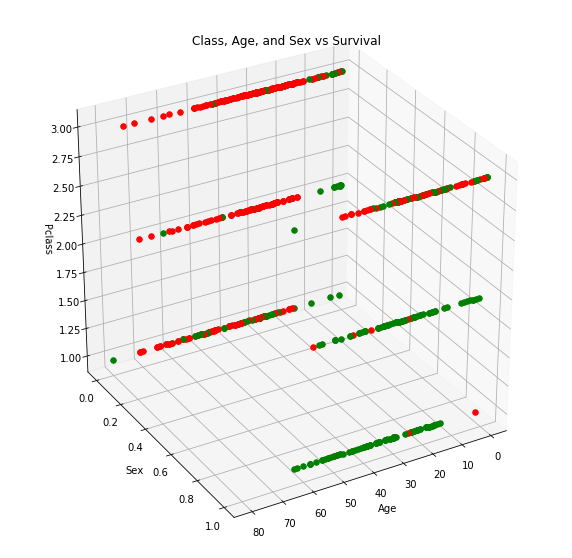

In [21]:
xs = titanic['Age']
ys = titanic['Sex'].apply(lambda x : 0 if x =='male' else 1)
zs = titanic['Pclass']
label = titanic['Survived']
data = zip(xs, ys, zs, label)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

for x, y, z, l in data:
    if l == 0:
        color = 'red'
    else:
        color = 'green'
    ax.scatter(x, y, z, s=30, label = l, c = color)

ax.view_init(30, 60)
ax.set_xlabel('Age')
ax.set_ylabel('Sex')
ax.set_zlabel('Pclass')
plt.title(f'Class, Age, and Sex vs Survival')
plt.show()



# I've commented out some code to animate this graph into a sweet spinning graph. It's great!


# def animate(i):
#     ax.view_init(30, i)
#     return plt.draw()

# anim = animation.FuncAnimation(fig, animate, frames = 360, interval = 20, blit = False)
    
# HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())

<Figure size 720x720 with 0 Axes>

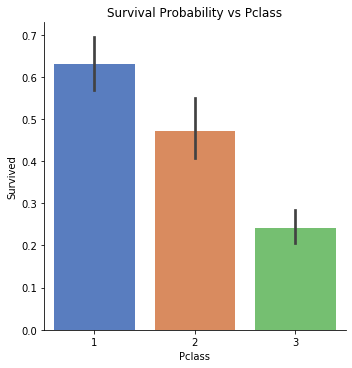

<Figure size 720x720 with 0 Axes>

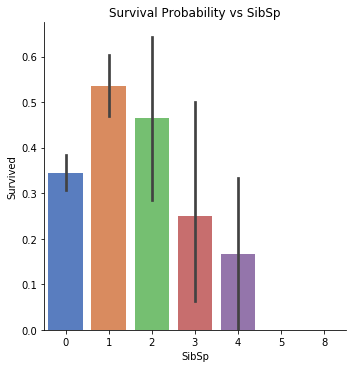

<Figure size 720x720 with 0 Axes>

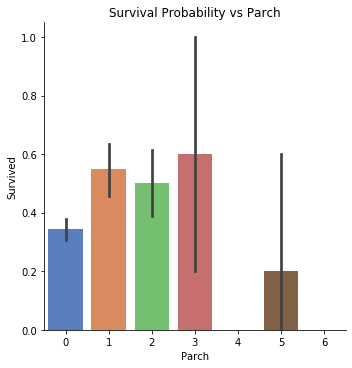

<Figure size 720x720 with 0 Axes>

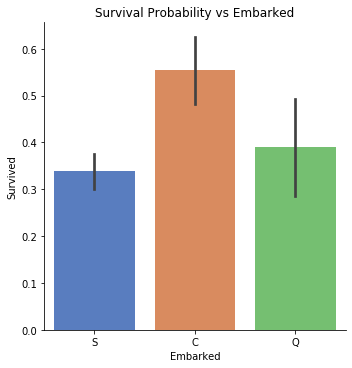

<Figure size 720x720 with 0 Axes>

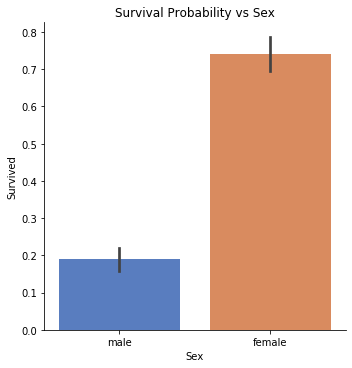

<Figure size 720x720 with 0 Axes>

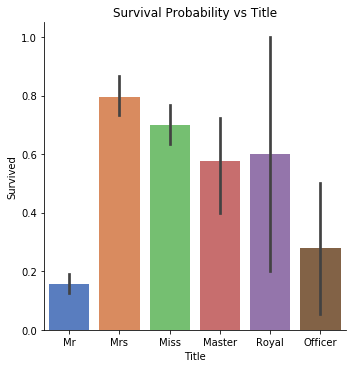

<Figure size 720x720 with 0 Axes>

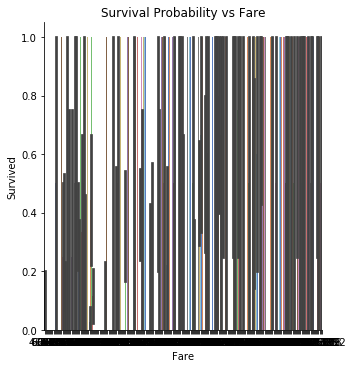

In [22]:
for feature in ['Pclass', 'SibSp', 'Parch', 'Embarked', 'Sex', 'Title', 'Fare']:

    plt.figure(figsize = (10, 10))
    graph = sns.catplot(x = feature, y = 'Survived', hue = None, data = titanic, kind="bar", palette="muted")
    plt.title(f'Survival Probability vs {feature}')
    plt.show()

<Figure size 1440x1440 with 0 Axes>

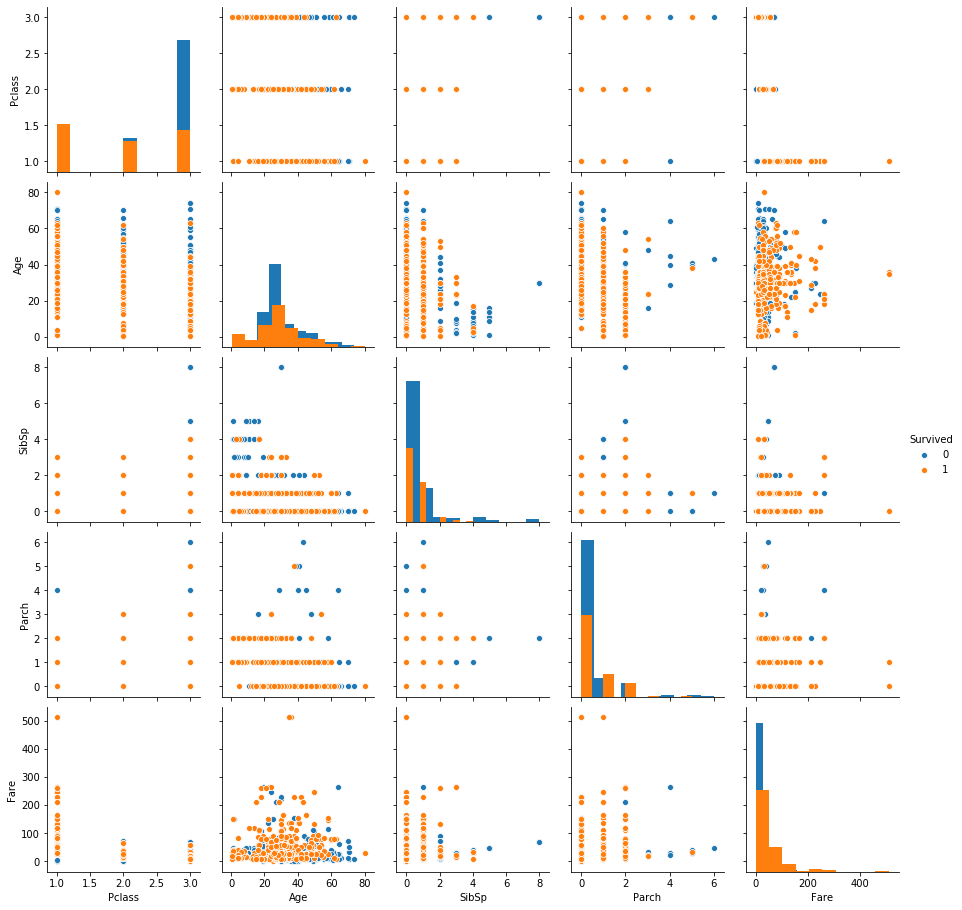

In [23]:
# It seems that the diagonal plots are the ones messing things up. The kde plot gets mad for some reason, something about bandwidth

plt.figure(figsize = (20, 20))
sns.pairplot(titanic, hue = 'Survived', diag_kind = 'hist')
plt.show()

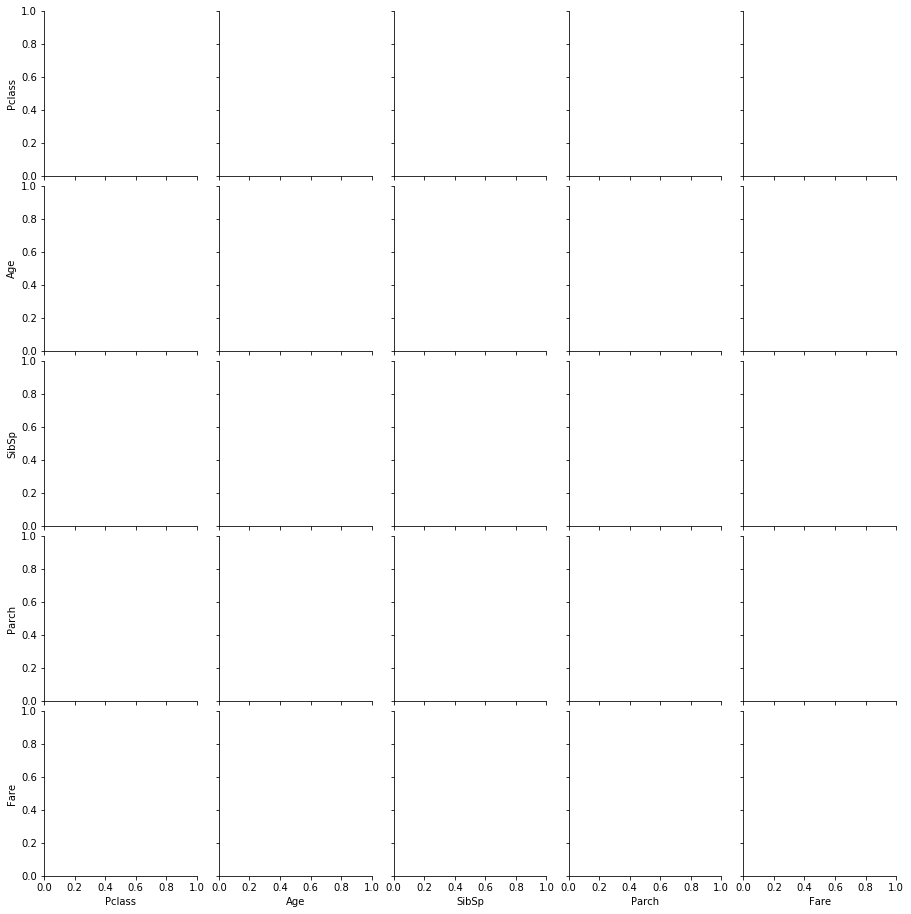

In [24]:
# Why doesn't this work?

sns.PairGrid(titanic, hue = 'Survived')
plt.show()

Wow! What beautiful graphs I've made!!  

From this, we can already draw a few conclusions: It seems like Men died more, 2nd and 3rd class folks died more, and the young and old lived more.

# Final Preprocessing

Now that we've finished graphing, we can do our final preprocessing, which will make the data better suited for modeling, but harder for humans to understand.

Now, LightGBM says it can handle Categorical Features in it's documentation. But it has failed when I've attempted it. I'm not sure if I'm making the mistake, or it the sklearn wrapper on LightGBM is interfering with this feature. Also, it may be that Anaconda is installing an older version of LightGBM which is missing this feature.

In any case, it's not that hard to take care of it myself. I'd better encode Sex, Embarked, and Honorific. Let's do Label Encoding for now.

We can test one-hot encoding later for comparison purposes.

In [25]:
display(titanic)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.000000,1,0,7.2500,S,Mr
1,1,1,female,38.000000,1,0,71.2833,C,Mrs
2,1,3,female,26.000000,0,0,7.9250,S,Miss
3,1,1,female,35.000000,1,0,53.1000,S,Mrs
4,0,3,male,35.000000,0,0,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,Officer
887,1,1,female,19.000000,0,0,30.0000,S,Miss
888,0,3,female,29.699118,1,2,23.4500,S,Miss
889,1,1,male,26.000000,0,0,30.0000,C,Mr


In [26]:
# Label Encoding

encoding = {
            'male': 0,
            'female' : 1,
            
            'S' : 0,
            'C' : 1,
            'Q' : 2,
            
            'Mr' : 0,
            'Mrs' : 1,
            'Master' : 2,
            'Royal' : 3,
            'Officer' : 4,
            'Miss' : 5,
           }



for feature in ['Title', 'Sex', 'Embarked']:
    titanic[feature] = titanic[feature].map(encoding)
    test[feature] = test[feature].map(encoding)

In [27]:
X_data = titanic.drop('Survived', axis = 1)
y_data = titanic['Survived']
X_test = test

In [28]:
# # One hot encoding
# titanic = pd.get_dummies(titanic)
# test = pd.get_dummies(test)

# Scaling the Data

Most ML models learn much better from data that is similarly scaled. So I will use a normal scaler to, well, normalize the data ranges.

In [29]:
# Scale the data!!
# Currently we're just scaling the X_data, but I'll probably need to do y_data as well

scaler = StandardScaler()
scaler.fit(X_data) 
X_data = pd.DataFrame(scaler.transform(X_data),columns = X_data.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

# So, PCA doesn't work without scaling, but everything else appears to be about the same without scaling. Hmmm

# Correlation Matrix



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
Survived,1.000000,-0.338481,0.543351,-0.069809,-0.035322,0.081629,0.257307,0.106811,0.409551
Pclass,-0.338481,1.000000,-0.131900,-0.331339,0.083081,0.018443,-0.549500,0.045702,-0.074317
Sex,0.543351,-0.131900,1.000000,-0.084153,0.114631,0.245489,0.182333,0.116569,0.738872
Age,-0.069809,-0.331339,-0.084153,1.000000,-0.232625,-0.179191,0.091566,0.007461,-0.244110
SibSp,-0.035322,0.083081,0.114631,-0.232625,1.000000,0.414838,0.159651,-0.059961,0.160889
Parch,0.081629,0.018443,0.245489,-0.179191,0.414838,1.000000,0.216225,-0.078665,0.180188
Fare,0.257307,-0.549500,0.182333,0.091566,0.159651,0.216225,1.000000,0.062142,0.147569
Embarked,0.106811,0.045702,0.116569,0.007461,-0.059961,-0.078665,0.062142,1.000000,0.169785
Title,0.409551,-0.074317,0.738872,-0.244110,0.160889,0.180188,0.147569,0.169785,1.000000


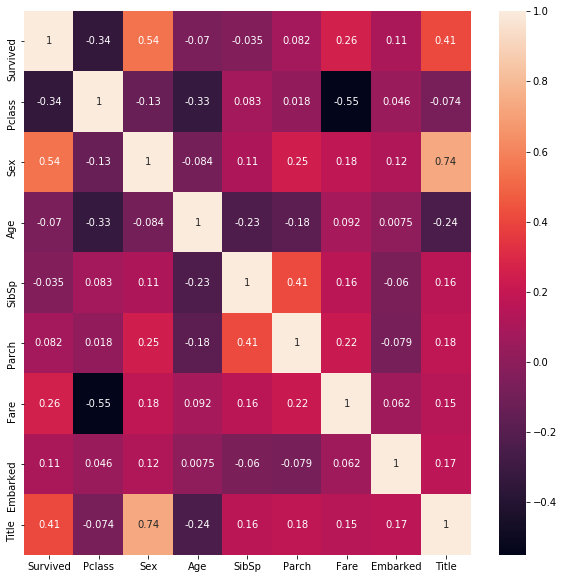

<Figure size 720x720 with 0 Axes>

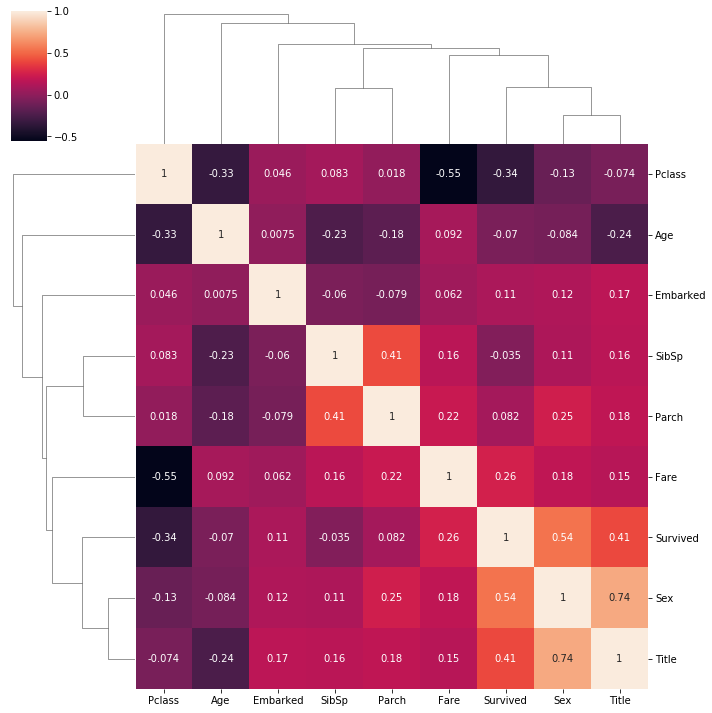

In [45]:
corr = titanic.corr()
display(corr)

plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True)
plt.show()

plt.figure(figsize = (10, 10))
sns.clustermap(corr, annot = True)
plt.show()

Here are some points of interest in the correlation matrix:
1. 

# PCA (Principal Component Analysis)

Principal Component Analysis (PCA) is a technique for understanding the data and for possible dimensionality reduction. In short, it finds a new basis for the data which maximizes the variance explained along each basis vector. In other words, it looks for the minimum amount of information to linearly explain the data.

It is important to scale your data before doing PCA! Otherwise, the feature with the largest scale (in our case, fare), will dominate, and we won't get a meaningful reduction.

In [31]:
pca = PCA()
pca.fit(X_data)
pca_data = pca.transform(X_data)

In [32]:
# Here we'll calculate the percent variance explained by each principal component.
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
for i in range(len(per_var)):
    print(f' Principal Component {i+1} explains {per_var[i]}% of the variance in our domain.')

 Principal Component 1 explains 27.4% of the variance in our domain.
 Principal Component 2 explains 21.2% of the variance in our domain.
 Principal Component 3 explains 16.5% of the variance in our domain.
 Principal Component 4 explains 11.4% of the variance in our domain.
 Principal Component 5 explains 9.0% of the variance in our domain.
 Principal Component 6 explains 7.2% of the variance in our domain.
 Principal Component 7 explains 4.5% of the variance in our domain.
 Principal Component 8 explains 2.9% of the variance in our domain.


Let's do some graphing to see what we can glean from this analysis.

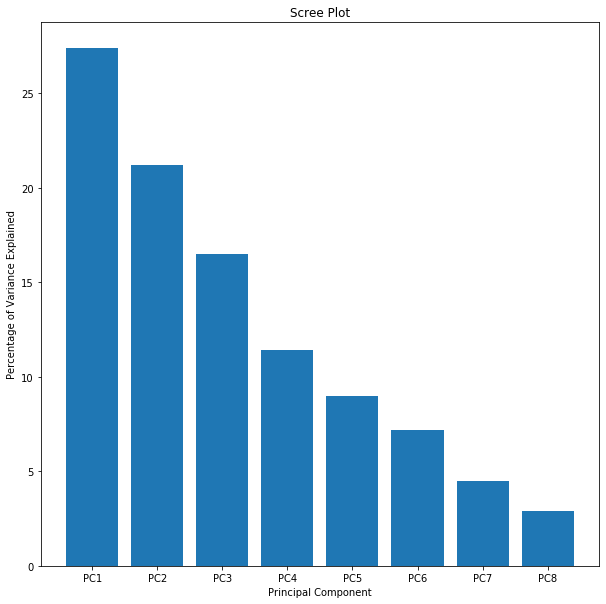

In [33]:
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.figure(figsize = (10, 10))
plt.bar(x = range(1, len(per_var) + 1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.autoscale()
plt.show()

Now let's do a PCA plot

In [34]:
pca_df = pd.DataFrame(pca_data, columns = labels)

pca_df['Survived'] = titanic['Survived']

display(pca_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Survived
0,-1.023219,-1.114884,0.567633,-0.072504,-0.407328,-0.443829,0.198870,-0.107188,0
1,1.043644,1.778284,-0.512136,0.585484,0.145030,-0.664550,-0.403676,-1.135858,1
2,1.081463,-0.814995,-1.525638,-1.502127,0.036237,-0.225174,0.563696,0.365831,1
3,0.820428,1.432009,0.163389,-0.824029,-0.059926,-0.756242,-0.426679,-1.102160,1
4,-1.513175,-0.375818,0.114943,-0.346167,0.221015,0.026222,0.485943,0.137897,0
...,...,...,...,...,...,...,...,...,...
886,-0.102231,0.013099,-0.462611,-0.835106,-0.619259,-0.209934,-0.439047,1.357284,0
887,1.697236,0.678554,-1.114391,-1.565548,-1.053569,-0.220513,-0.916362,0.130843,1
888,2.371143,-1.121577,0.078879,-0.962268,1.258449,0.719957,0.282559,0.641603,0
889,-0.715216,1.091638,-0.235789,0.922561,-0.829671,0.157915,-1.278693,-0.213143,1


In [ ]:
# Do a 1D PCA graph here

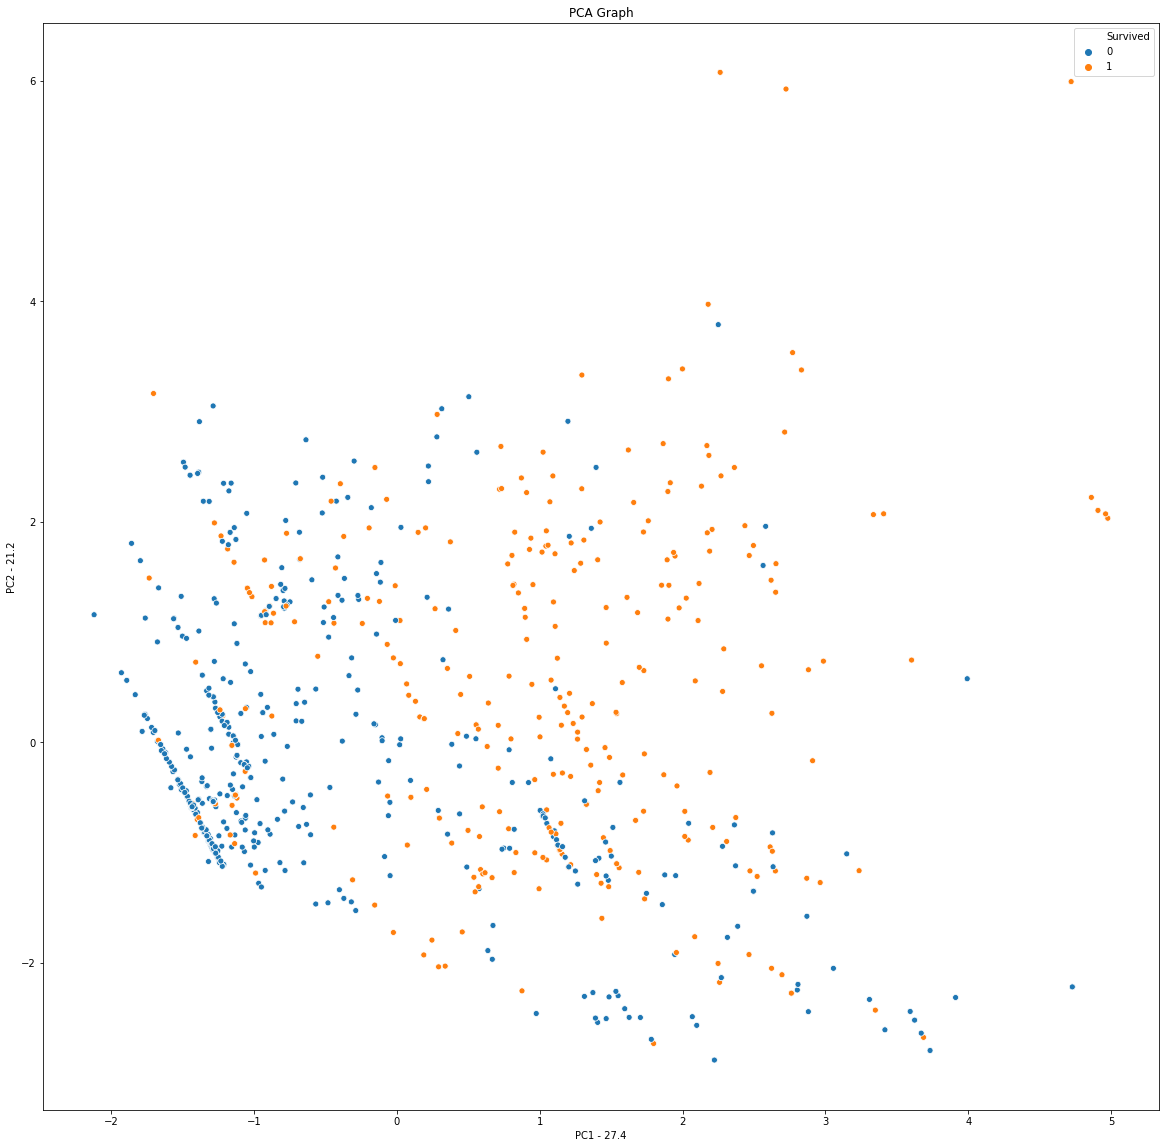

In [35]:
plt.figure(figsize = (20, 20))
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Survived', data = pca_df)
plt.title('PCA Graph')
plt.xlabel(f'PC1 - {per_var[0]}')
plt.ylabel(f'PC2 - {per_var[1]}')
plt.show()

We would expect this graph to explain 27.4 + 21.2 = 48.6 percent of the variance.

We can see that already there is some good seperation of survived vs. not with just these two components. But there's a ton more seperation needed. Let's see how it looks in 3D.

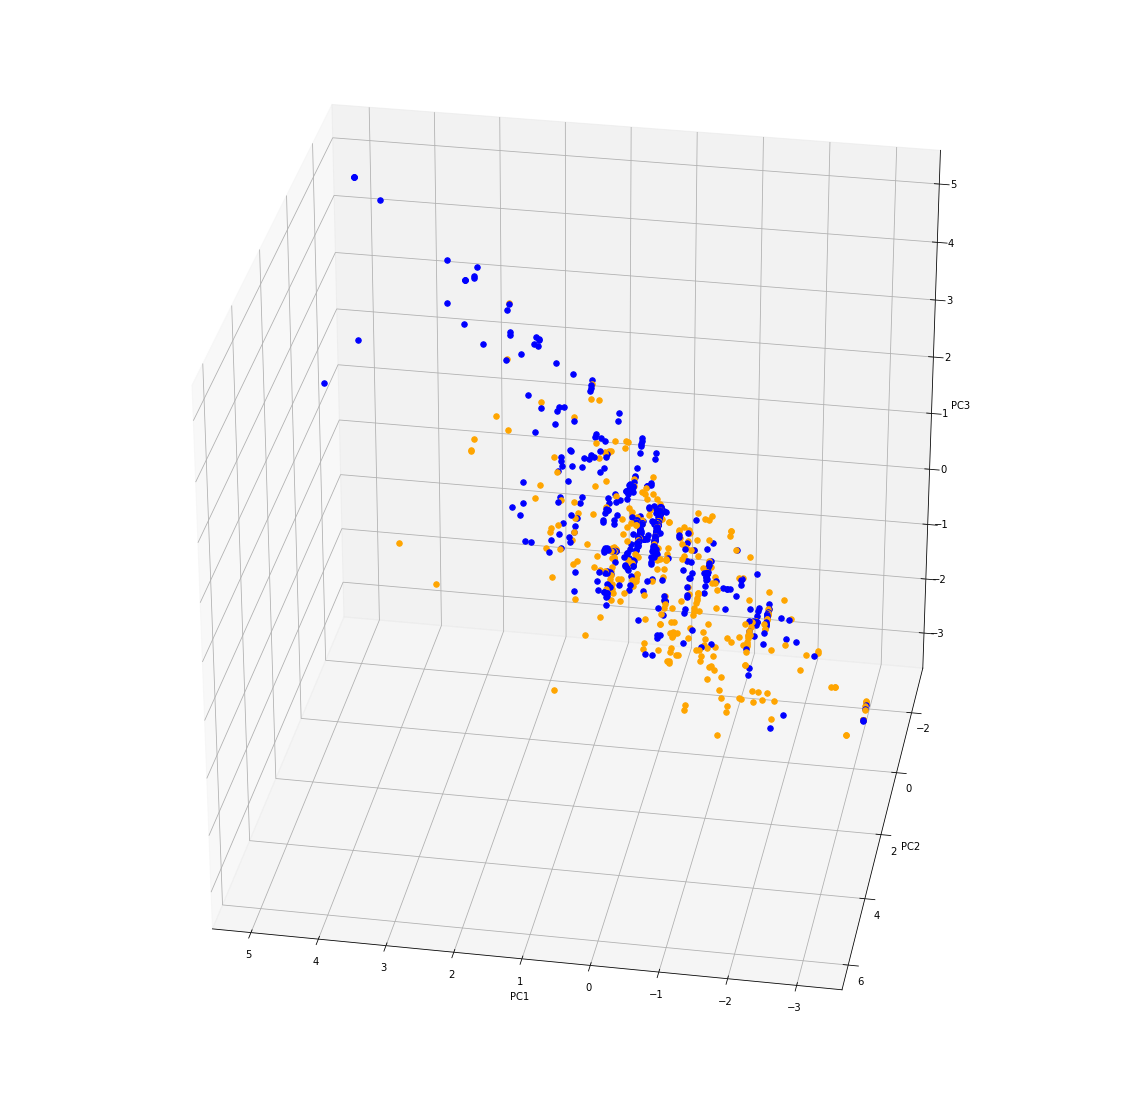

In [54]:
xs = pca_df.PC1
ys = xs = pca_df.PC2
zs = xs = pca_df.PC3
label = pca_df.Survived
data = zip(xs, ys, zs, label)

fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111, projection='3d')

for x, y, z, l in data:
    if l == 0:
        color = 'blue'
    else:
        color = 'orange'
    ax.scatter(x, y, z, s=30, label = l, c = color)

ax.view_init(30, 100)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

# def animate(i):
#     ax.view_init(30, i)
#     return plt.draw()

# anim = animation.FuncAnimation(fig, animate, frames = 360, interval = 20, blit = False)
    
# HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())

We would expect this graph to explain 27.4 + 21.2 + 16.5 = 65.1 percent of the variance.

In [37]:
for i in range(len(per_var)):
    print(f'Weights for PC{i+1}')
    loading_scores = pd.Series(pca.components_[i], index = X_data.columns)
    sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
    display(loading_scores[sorted_loading_scores.index.values])
    print('')
    
# sns.barplot(data = loading_scores)

Weights for PC1


Title       0.536555
Sex         0.532779
Parch       0.383637
SibSp       0.324142
Fare        0.321037
Age        -0.200939
Pclass     -0.152430
Embarked    0.096611
dtype: float64


Weights for PC2


Pclass     -0.650545
Age         0.511162
Fare        0.476591
SibSp      -0.242489
Parch      -0.153488
Title      -0.061231
Embarked    0.034167
Sex         0.033003
dtype: float64


Weights for PC3


Embarked   -0.486407
SibSp       0.472808
Parch       0.443504
Title      -0.380367
Sex        -0.338512
Fare        0.263679
Pclass     -0.116568
Age        -0.027929
dtype: float64


Weights for PC4


Embarked    0.842561
Sex        -0.302823
SibSp       0.258962
Fare        0.254518
Title      -0.220482
Parch       0.095670
Pclass      0.083390
Age        -0.042779
dtype: float64


Weights for PC5


Age         0.771175
Parch       0.393236
Fare       -0.355071
Pclass      0.215823
Sex         0.209354
SibSp       0.151461
Embarked    0.099692
Title      -0.035929
dtype: float64


Weights for PC6


SibSp      -0.713304
Parch       0.650476
Age        -0.178542
Title      -0.144650
Fare        0.090493
Embarked    0.063392
Pclass      0.055040
Sex        -0.006352
dtype: float64


Weights for PC7


Pclass      0.692216
Fare        0.632301
Age         0.193606
Parch      -0.181542
Embarked   -0.160855
Sex         0.126096
SibSp      -0.091701
Title      -0.020213
dtype: float64


Weights for PC8


Title       0.701744
Sex        -0.670071
Age         0.177918
Parch       0.112716
SibSp      -0.073278
Pclass      0.065136
Embarked   -0.056273
Fare        0.037696
dtype: float64

Very interesting. So, what these numbers say is that, in order to explain the biggest chunk of variance possible (in this case, 24.4%), we look mostly at Sex, and a bit at certian titles......

However, in general, we need 6 out of the 8 Principal Components to explain at least 90% of the variance (actually 92.7%). This means that we could safely remove the last one or two principal components, without losing much information.

However, this has NOTHING to do with the shape of the data, only the dimensionality of the data. What we can conclude is that the data is essentially 6 or 7 dimensional. But we will have to dig deeper to find the shape of the data. It may be very close to a line in those 6 or 7 dimensions (for example, a multi-dimensional cylinder). But we can't meaningfully reduce it to a 2 or 3 dimensional shape that we as humans could visualize.

# Model 1 (Linear Classifier)

Let's start with the simpelest model, a Linear Regression Classifier. In particular, we'll use a Logistic Classifier, which ... (add a description here)

In [38]:
n_iter = 100

param_test = {
                'max_iter': range(1, 1001),
                 'penalty': ['l2']
            }


model = LogisticRegression(n_jobs=3, verbose = -1)


rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='roc_auc',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = n_iter,
            n_jobs = 3
            )

rs.fit(X_data, y_data)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = LogisticRegression(**rs.best_params_)

model.fit(X_data, y_data)

predict = model.predict(X_test)

output = pd.DataFrame({'PassengerID': test_id, 'Survived': predict})

output.to_csv(f'{filepath}submit_linear.csv',index=False, header =1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    8.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   17.0s


Best score reached: 0.8487164673317563 with params: {'penalty': 'l2', 'max_iter': 245} 


[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   19.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished


[Parallel(n_jobs=2)]: Done 465 tasks      | elapsed:    8.6s  
Best score reached: 0.8487164673317563 with params: {'penalty': 'l2', 'max_iter': 957}   

Best score reached: 0.8487164673317563 with params: {'penalty': 'l2', 'max_iter': 333}   
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    9.8s finished  

Best score reached: 0.8487164673317563 with params: {'penalty': 'l2', 'max_iter': 490}  
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    7.8s finished  


Best score reached: 0.8487164673317563 with params: {'penalty': 'l2', 'max_iter': 10}   
[Parallel(n_jobs=3)]: Done 5000 out of 5000 | elapsed:  3.0min finished  


Wow! For a simple linear model, the results are pretty good! 86% accuracy! Let's upload to Kaggle for comparison.

Kaggle: 0.78947

So about 79%. Wow, that's fantastic for a linear model!

I think what this goes to show is that preprocessing is WAY more important than model selection.

Though, this may also be because the Titanic data is relatively small and simple.

Hmmm, the score went down slightly when I normalized the data. That's interesting...

# Model 2 (Decision Tree)

Next, let's look at a basic decision tree.

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Done 410 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    0.7s finished


Best score reached: 0.8500089944234575 with params: {'max_depth': 4} 


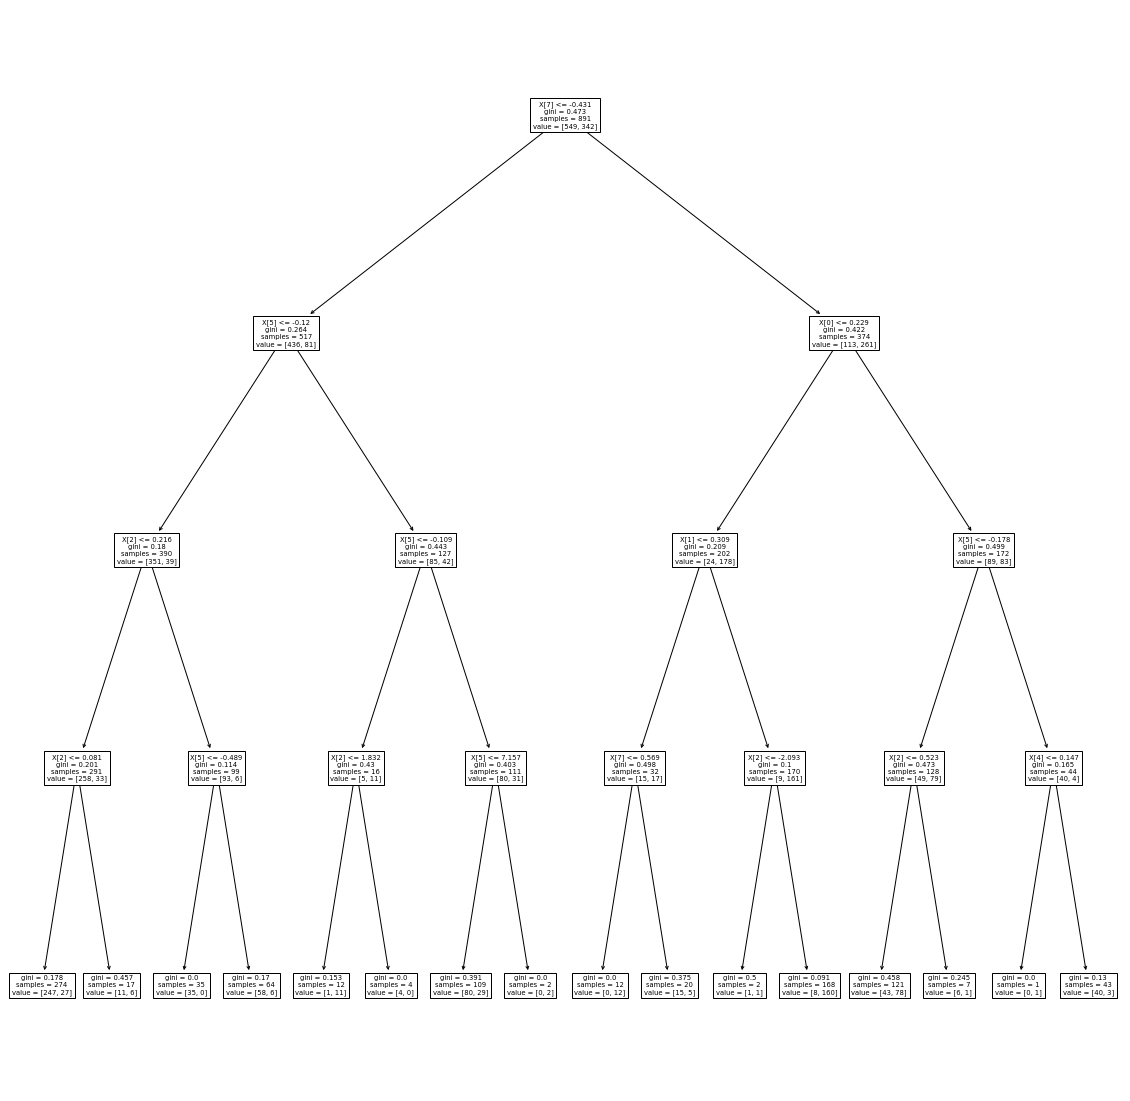

In [39]:
n_iter = 100

param_test = {
                'max_depth' : range(1, 101)
            }


model = DecisionTreeClassifier()


rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='roc_auc',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = n_iter,
            n_jobs = 3
            )

rs.fit(X_data, y_data)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = DecisionTreeClassifier(**rs.best_params_)

model.fit(X_data, y_data)

predict = model.predict(X_test)

output = pd.DataFrame({'PassengerID': test_id, 'Survived': predict})

output.to_csv(f'{filepath}submit_dt.csv',index=False, header =1)

plt.figure(figsize = (20,20))
plot_tree(model)
plt.show()

Wow! Already 85% accuracy, with a decision tree. Things to note:
1. This is essentially the same accuracy as the linear model.
2. Cross validation was enough to limit overfitting, which is a common issue with simple decision trees.

Again, this demostrates the importance of preprocessing.

# Model 3 (Random Forest)

Now let's try a random forest. This technique involves an ensemble of trees, each of which only look at a selection of data and features. We then look at what the majority of the trees predict as our final prediction. This helps limit overfitting to the training data.

In [40]:
n_iter = 100

param_test = {
                'max_depth' : range(1, 101),
                'n_estimators' : range(1, 101)
            }


model = RandomForestClassifier(n_jobs = 3)


rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='roc_auc',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = n_iter,
            n_jobs = 3
            )

rs.fit(X_data, y_data)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = RandomForestClassifier(**rs.best_params_)

model.fit(X_data, y_data)

predict = model.predict(X_test)

output = pd.DataFrame({'PassengerID': test_id, 'Survived': predict})

output.to_csv(f'{filepath}submit_rf.csv',index=False, header =1)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   17.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   39.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   44.3s finished


Best score reached: 0.8711807367179384 with params: {'n_estimators': 59, 'max_depth': 7} 


In [41]:
# Make some better graphs for this stuff. Plot feature importance, and some of the trees, if you can.

display(model.feature_importances_)

display(model.estimators_[0])

array([0.1184184 , 0.2842123 , 0.11351114, 0.06370812, 0.032662  ,
       0.15965112, 0.02940988, 0.19842704])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=957784526, splitter='best')

Oh snap! 87% accuracy, with just random forest!! That's great!

# Model 3 (LightGBM)

Let's chuck it in a Light GBM Random Search, and see what we come up with.

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:   10.1s
[Parallel(n_jobs=3)]: Done 260 tasks      | elapsed:   34.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  1.2min finished


Best score reached: 0.8721334185848253 with params: {'num_leaves': 3, 'n_estimators': 220, 'learning_rate': 0.04} 


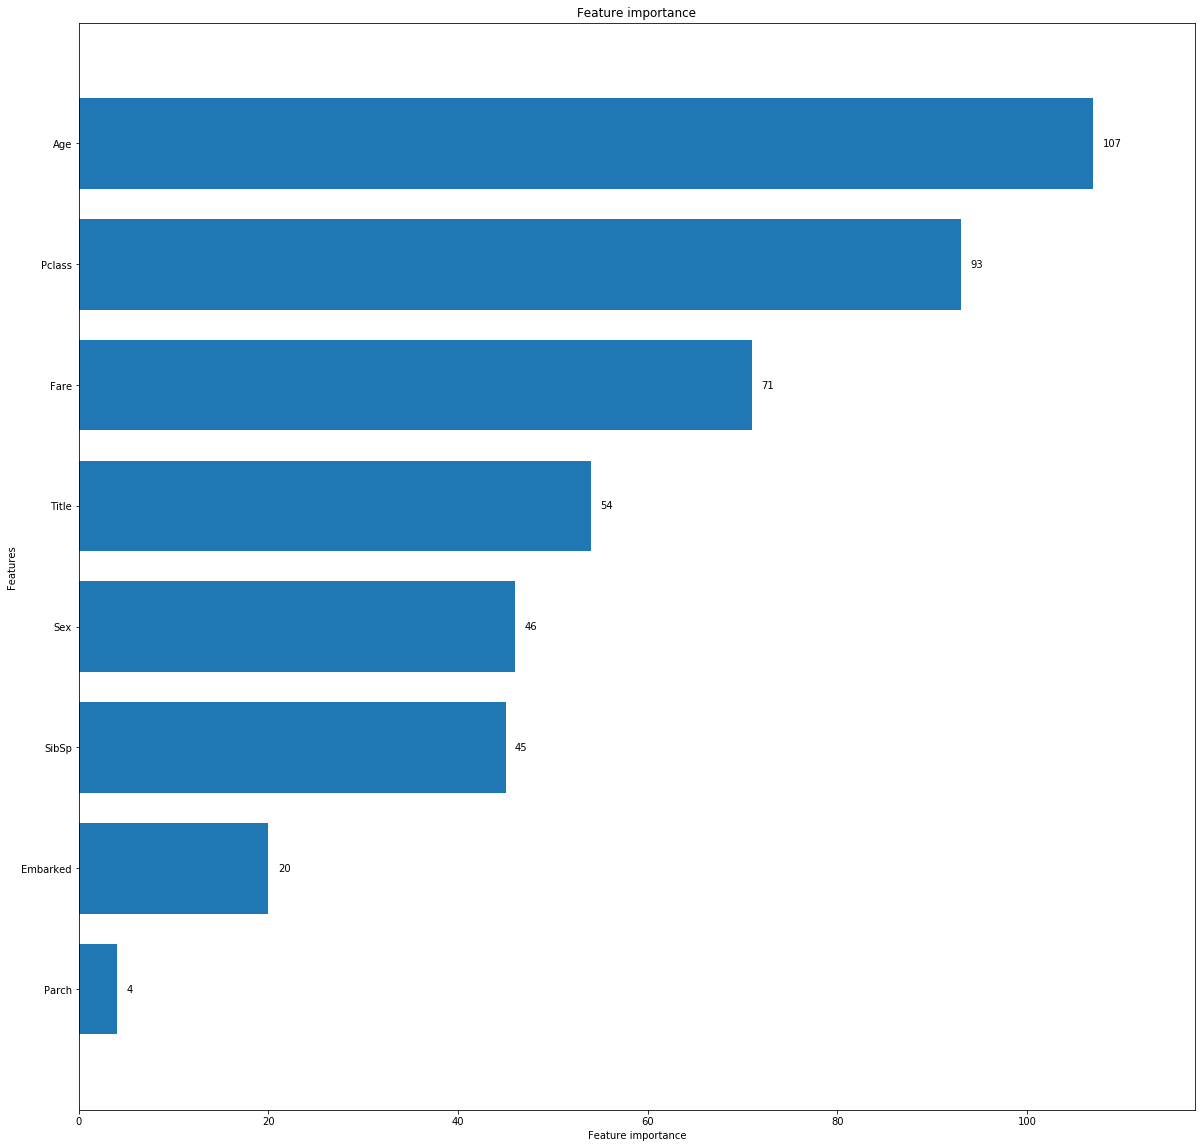

In [42]:
n_iter = 100

param_test = {
                'num_leaves': range(2, 10), 
                'learning_rate': [.001, .002, .003, .004, .005, .006, .007, .008, .009, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(100, 5000, 10)
            }


model = lgb.LGBMClassifier(silent=True, n_jobs=3, verbose = -1)


rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='roc_auc',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = n_iter,
            n_jobs = 3
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = lgb.LGBMClassifier(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'PassengerID': test_id, 'Survived': predict})

output.to_csv(f'{filepath}submit_lgb.csv',index=False, header =1)

lgb.plot_importance(model, height = .75, figsize = (20, 20), grid = False)
plt.show()

# Scoring 1

[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:  6.9min finished  
Best score reached: 0.8726335778536676 with params: {'num_leaves': 3, 'n_estimators': 271, 'learning_rate': 0.03}  
Kaggle: 0.77511%which is about 6000 place out of 16488 on Kaggle, or roughly 38 percentile.

[Parallel(n_jobs=2)]: Done 25000 out of 25000 | elapsed: 23.0min finished  
Best score reached: 0.8730598584213757 with params: {'num_leaves': 3, 'n_estimators': 140, 'learning_rate': 0.06}   
Kaggle:  0.77511%, which is about 6000 place out of 16488 on Kaggle, or roughly 38 percentile.

[Parallel(n_jobs=2)]: Done 50000 out of 50000 | elapsed: 224.1min finished  
Best score reached: 0.8723611552537032 with params: {'num_leaves': 3, 'n_estimators': 180, 'learning_rate': 0.05}  
Kaggle:  0.77511%, which is about 6000 place out of 16488 on Kaggle, or roughly 38 percentile.

[Parallel(n_jobs=3)]: Done 50000 out of 50000 | elapsed: 115.5min finished  
Best score reached: 0.8741122966211542 with params: {'num_leaves': 3, 'n_estimators': 3270, 'learning_rate': 0.002}  
Kaggle:  0.77033%, which is about 6000 place out of 16488 on Kaggle, or roughly 38 percentile.

Label Encode + honorific = 14000 place, 0.74162% accuracy  
Label Encode - honorific = 9800 place, 0.77511% accuracy  
One Hot - Honorific = 3740 place, 0.78947% accuracy  
Above, but 1000 rs iterations =  0.77511% accuracy

# Conclusions 1

At this point, we aren't really adding much predictive power to our model by hyperparameter tuning, since "better" hyperparameter tuning leads to lower scores on Kaggle. While we could continue to tinker, we would only be overfitting our model to the test data (the data on Kaggle).  

This is important to remember in any competition: the purpose of a model is to be able to generalize well. It isn't worth trying to tune hyperparameters for minor score improvements on the leaderboard. The purpose of test data is to say "Now that I'm 100% convinced I've made the best model I can based on the training data, let me see how well it generalizes based on the test data." Don't change your model based on the test data, unless you come up with some new methods for data cleaning, feature generation / selection, or different hyperparameters to try, and you want to rebuild your model from scratch.

In the end, our model is pretty good. It predicts with, in general, 87% accuracy. It happened to get 79% on Kaggle, but with another test set it might do better or worse. The point is that our model can generalize substantially better than 50%, which means we're doing much better than randomly guessing.

# Further Visualizations

It can be hard to understand what is happening with this type of modeling. Here are some of the trees used in our final model. Remember that this method generates a tree, then generates a new tree to correct the mistakes of the old tree, and keeps doing this until a certian threshold. Then it takes a weighted average of all the trees.  

Looking at the trees, you'll notice that each one wouldn't do a very good job on it's own. That's on purpose! We don't want to over fit the data. Each of these trees is a "weak classifier", and captures some aspect of the data structure. Then the next tree tries to capture a different aspect of the data structure by learning from the previous tree. On their own, they are not good, but together they form a powerful "ensemble" for exploring the data structure.

Hold on to your mouse wheel...

Here are some of the 220 trees used in our final model.


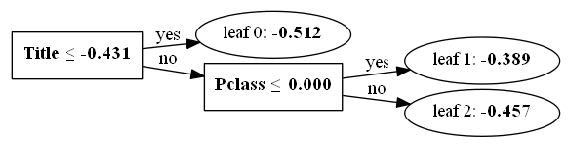

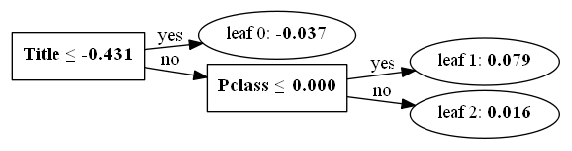

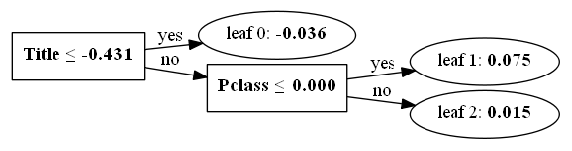

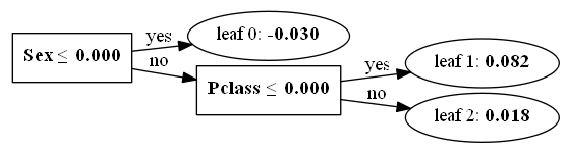

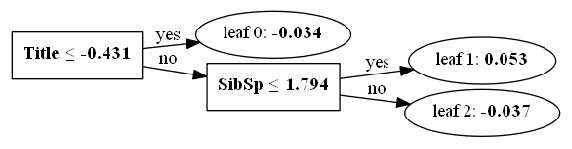

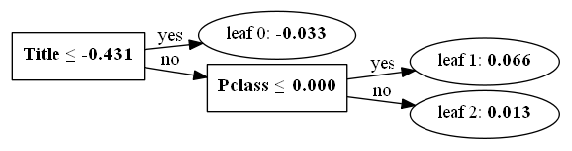

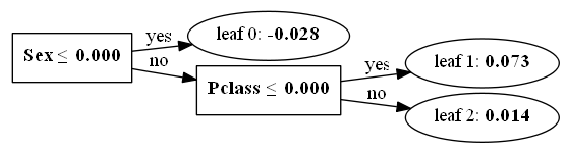

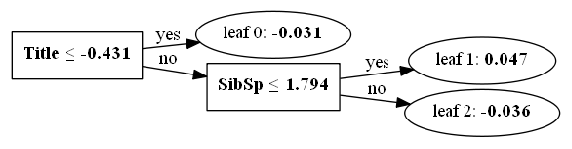

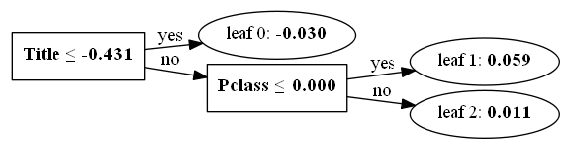

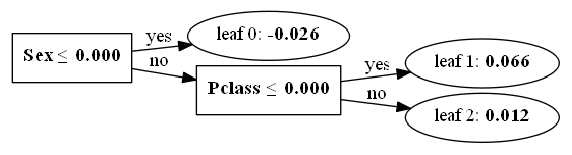

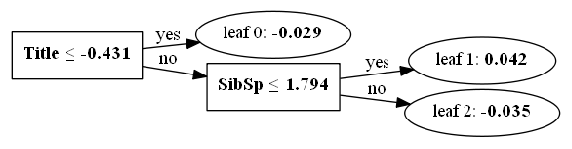

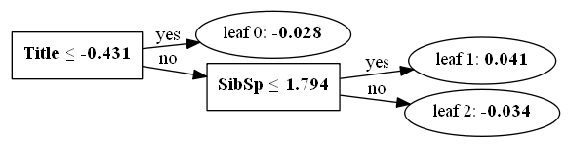

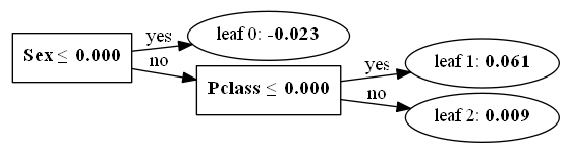

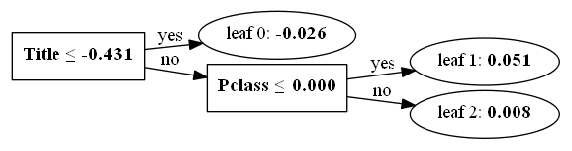

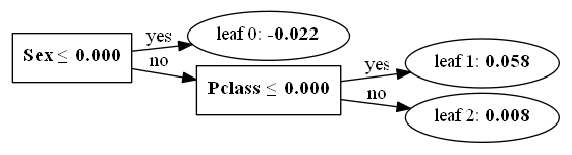

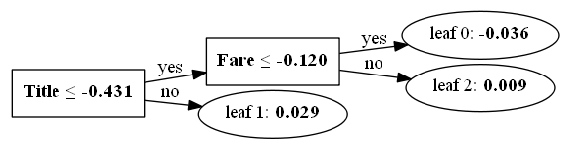

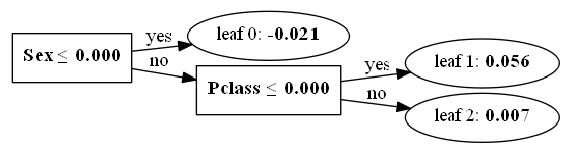

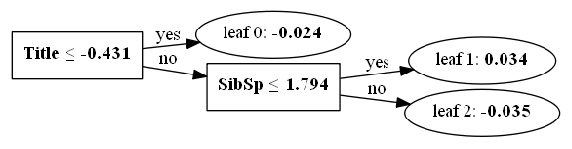

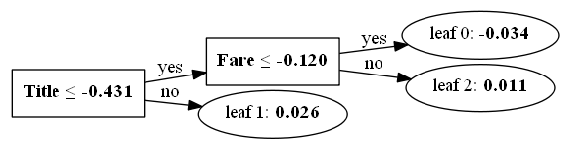

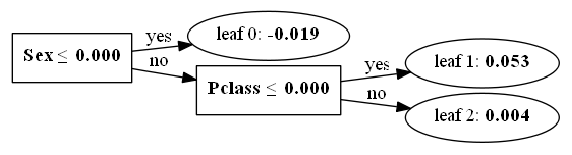

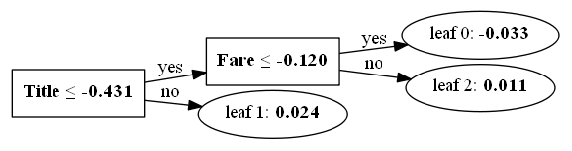

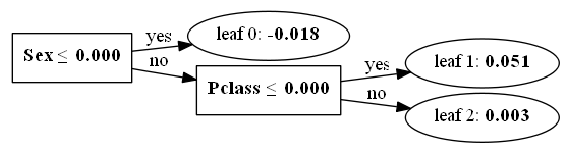

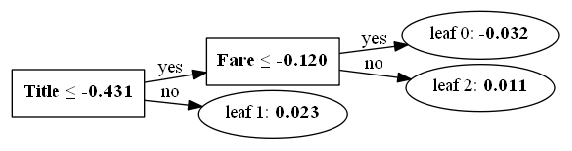

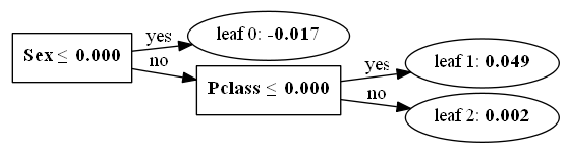

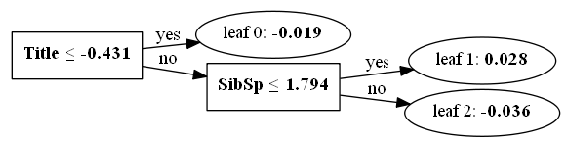

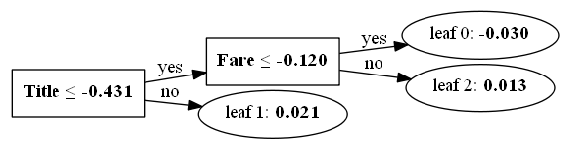

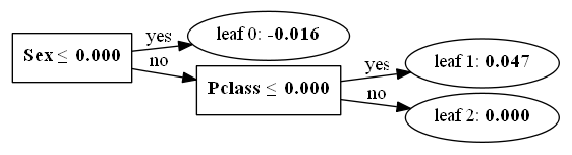

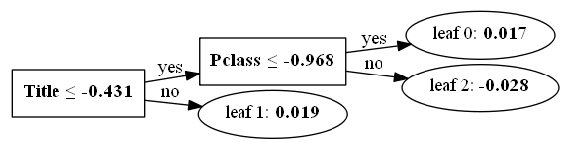

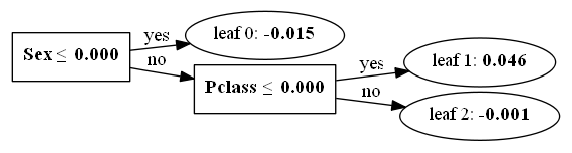

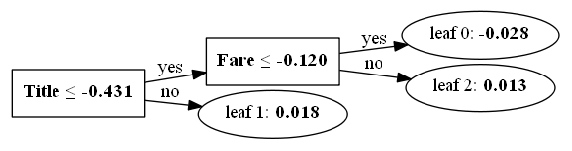

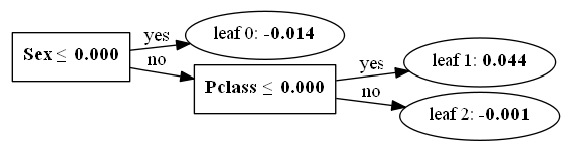

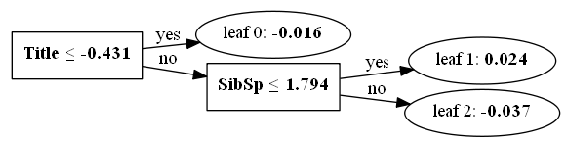

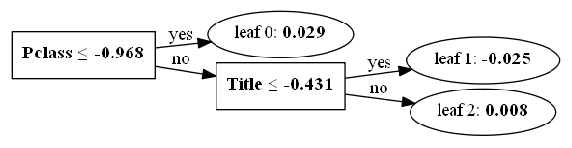

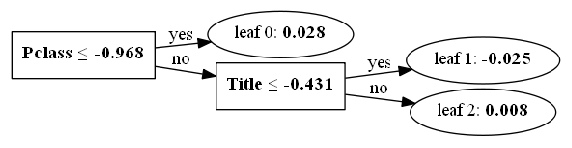

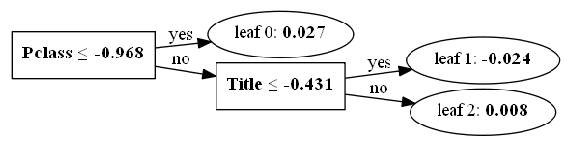

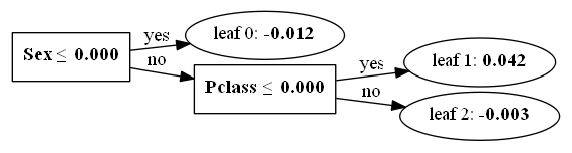

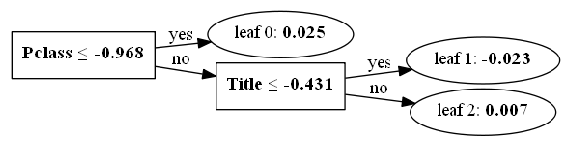

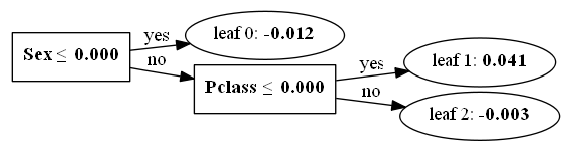

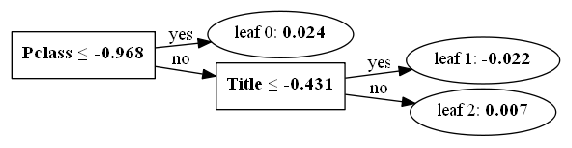

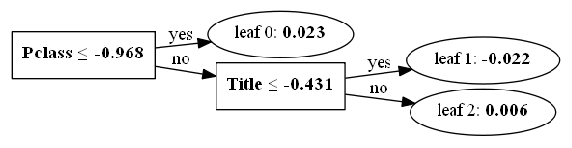

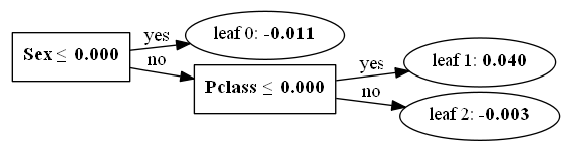

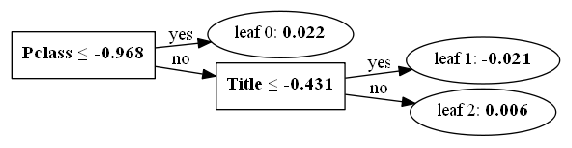

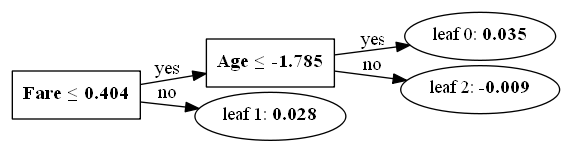

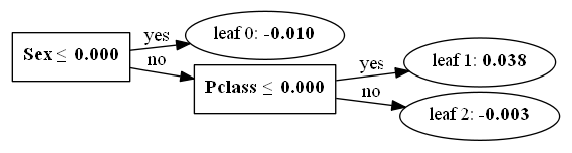

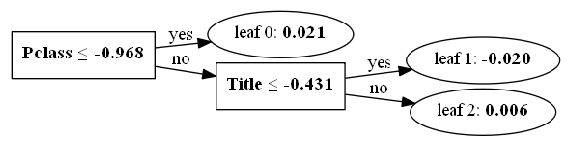

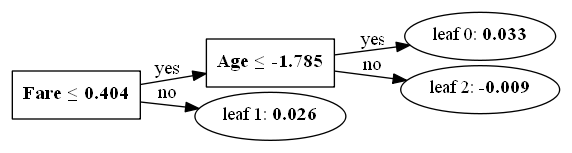

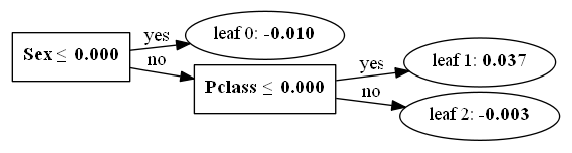

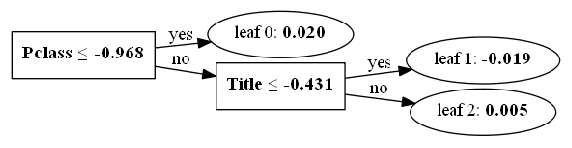

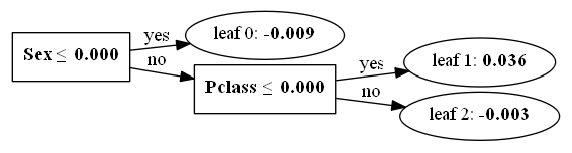

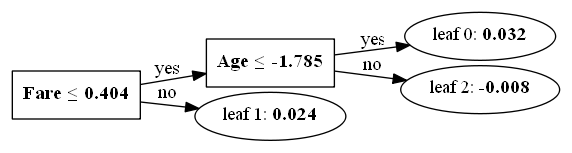

In [43]:
num_trees = rs.best_params_['n_estimators']

print(f'Here are some of the {num_trees} trees used in our final model.')

for i in range(min(50, num_trees)):
    lgb.plot_tree(model, figsize = (10, 10), tree_index = i)